### Basic Imports

In [1]:
import matplotlib.pyplot as plt
import torch

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Download some MNIST to demonstrate super-resolution
from torchvision import datasets, transforms
mnist = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())




In [3]:
# Displaying an image
def show_image(img):
    plt.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')

# Displaying a batch of images
def show_batch(batch):
    grid = torch.cat([batch[i] for i in range(batch.shape[0])], dim=1)
    show_image(grid)
    

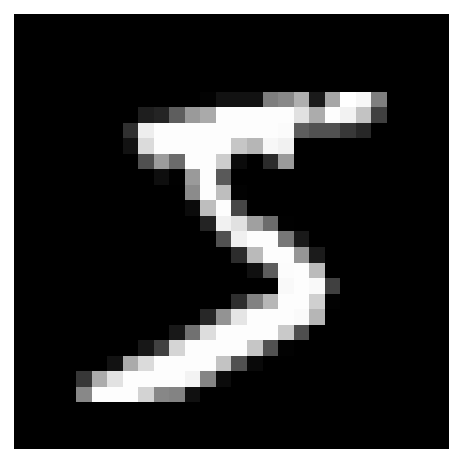

In [4]:
show_image(mnist[0][0])

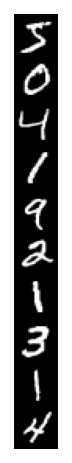

In [5]:
show_batch(torch.stack([mnist[i][0] for i in range(10)]))

In [6]:
mnist[0][0].shape

torch.Size([1, 28, 28])

In [72]:
# Downsample the images
downsample = transforms.Resize(7)

# First 10000 images X
mnist_small = [downsample(mnist[i][0]) for i in range(10000)]
mnist_small = torch.stack(mnist_small)

# First 10000 images Y
mnist_large = torch.stack([mnist[i][0] for i in range(10000)])

# Test set X
mnist_test_small = [downsample(mnist_test[i][0]) for i in range(10000)]
mnist_test_small = torch.stack(mnist_test_small)

# Test set Y
mnist_test_large = torch.stack([mnist_test[i][0] for i in range(10000)])



/home/nipun.batra/miniforge3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


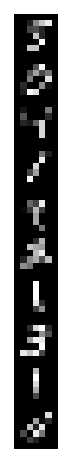

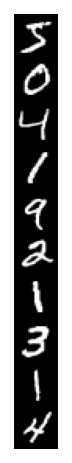

In [64]:
# Show the downsampled images and the original images side-by-side

show_batch(torch.stack([mnist_small[i] for i in range(10)]))
plt.figure()
show_batch(torch.stack([mnist[i][0] for i in range(10)]))

In [65]:
mnist_small.shape, mnist.data.shape

(torch.Size([10000, 1, 7, 7]), torch.Size([60000, 28, 28]))

In [66]:
import torch
import torch.nn as nn

class SinActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

# Create an instance of the custom SinActivation module
sin_activation = SinActivation()

class UNet(nn.Module):
    def __init__(self, activation=sin_activation):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # Input: (batch_size, 1, 7, 7), Output: (batch_size, 16, 7, 7)
            # Use the custom activation function
            activation,
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # Input: (batch_size, 16, 7, 7), Output: (batch_size, 32, 7, 7)
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2)  # Input: (batch_size, 32, 7, 7), Output: (batch_size, 32, 3, 3)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Input: (batch_size, 32, 3, 3), Output: (batch_size, 64, 3, 3)
            activation,
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=4, padding=0),  # Input: (batch_size, 64, 3, 3), Output: (batch_size, 32, 12, 12)
            activation,
            # Input (batch_size, 32, 12, 12), Output: (batch_size, 16, 12, 12)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=0),
            activation,
            # Input (batch_size, 16, 12, 12), Output: (batch_size, 1, 28, 28)
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)
            
            )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)

        # Bottleneck
        x = self.bottleneck(x1)

        # Decoder
        x = self.decoder(x)

        return x

# Create an instance of the modified UNet model
model = UNet(nn.GELU())

# Print the model architecture with input and output shape
batch_size = 1
input_size = (batch_size, 1, 7, 7)
dummy_input = torch.randn(input_size)
output = model(dummy_input)
print(model)
print(f"Input shape: {input_size}")
print(f"Output shape: {output.shape}")


UNet(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(4, 4))
    (1): GELU(approximate='none')
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): GELU(approximate='none')
    (4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)
Input shape: (1, 1, 7, 7)
Output shape: torch.Size([1, 1, 28, 28])


In [67]:
# Provide an example input to the model
batch_size = 1
input_size = (batch_size, 1, 7, 7)
dummy_input = torch.randn(input_size)

# Export the model to ONNX
onnx_path = "unet_model.onnx"
torch.onnx.export(model, dummy_input, onnx_path, verbose=True)

print("Model exported to ONNX successfully.")

Exported graph: graph(%input.1 : Float(1, 1, 7, 7, strides=[49, 49, 7, 1], requires_grad=0, device=cpu),
      %encoder.0.weight : Float(16, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.0.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %encoder.2.weight : Float(32, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.2.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %bottleneck.0.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cpu),
      %bottleneck.0.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %decoder.0.weight : Float(64, 32, 4, 4, strides=[512, 16, 4, 1], requires_grad=1, device=cpu),
      %decoder.0.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %decoder.2.weight : Float(32, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=cpu),
      %decoder.2.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      

![](unet_model.onnx.svg)

In [68]:
# Input to the model is a batch of 1-channel 7x7 images
batch_size = 1
input_size = (batch_size, 1, 7, 7)

# Create an instance of the modified UNet model

# Output of the model is a batch of 1-channel 28x28 images
output_size = (batch_size, 1, 28, 28)




In [98]:
# Create X_train, Y_train, X_test, Y_test

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = mnist_small.float().to(device)
Y_train = mnist_large.float().to(device)

X_test = mnist_test_small.float().to(device)
Y_test = mnist_test_large.float().to(device)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

model = UNet(activation=nn.ReLU()).to(device)


In [99]:
# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train on full 100 samples

# Number of epochs
n_epochs = 5000

# List to store losses
losses = []

# Loop over epochs
for epoch in range(n_epochs):
    # Forward pass
    Y_pred = model(X_train)

    # Compute Loss
    loss = loss_fn(Y_pred, Y_train)

    # Print loss
    if epoch % 50 == 0:
        print(f"Epoch {epoch+1} loss: {loss.item()}")

    # Store loss
    losses.append(loss.item())

    # Zero the gradients
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Update the weights
    optimizer.step()


Epoch 1 loss: 0.11675256490707397
Epoch 51 loss: 0.06216473504900932
Epoch 101 loss: 0.04350370541214943
Epoch 151 loss: 0.0338316448032856
Epoch 201 loss: 0.030034823343157768
Epoch 251 loss: 0.02791508287191391
Epoch 301 loss: 0.026423178613185883
Epoch 351 loss: 0.025394216179847717
Epoch 401 loss: 0.024557942524552345
Epoch 451 loss: 0.023918969556689262
Epoch 501 loss: 0.02341558039188385
Epoch 551 loss: 0.02270268276333809
Epoch 601 loss: 0.022382188588380814
Epoch 651 loss: 0.021941369399428368
Epoch 701 loss: 0.02154976688325405
Epoch 751 loss: 0.021203456446528435
Epoch 801 loss: 0.020942917093634605
Epoch 851 loss: 0.020651856437325478
Epoch 901 loss: 0.020434202626347542
Epoch 951 loss: 0.020613599568605423
Epoch 1001 loss: 0.02005993388593197
Epoch 1051 loss: 0.019821004942059517
Epoch 1101 loss: 0.019648907706141472
Epoch 1151 loss: 0.019410282373428345
Epoch 1201 loss: 0.01924115978181362
Epoch 1251 loss: 0.019102536141872406
Epoch 1301 loss: 0.019002726301550865
Epoch 13

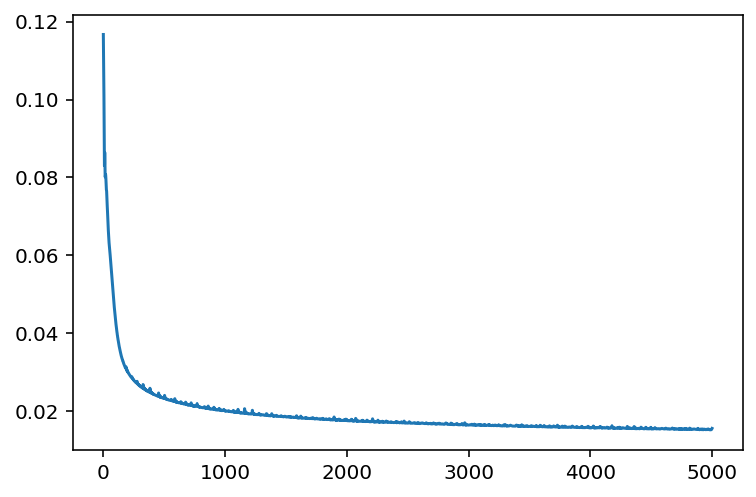

In [100]:
# Plot the losses
plt.plot(losses)

### Viz. super resolution on a subset of train images

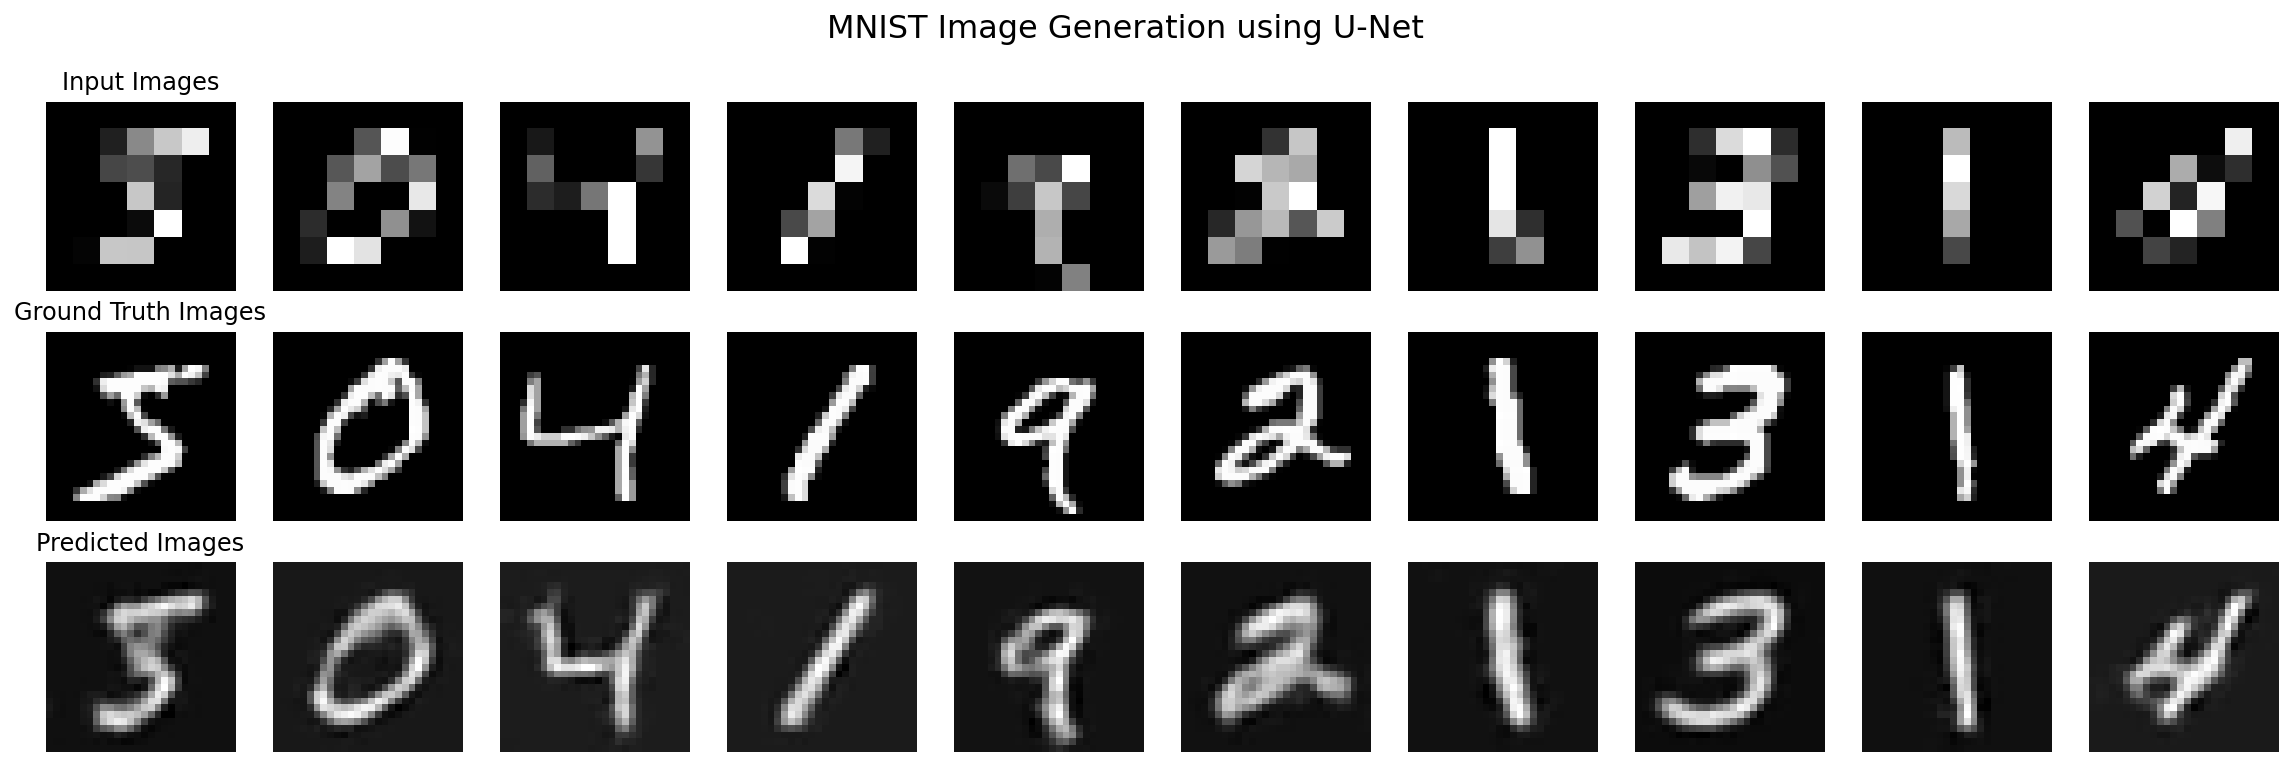

In [101]:
# Extract a mini-batch of 10 images
X_mini = X_train[:10]
Y_mini = Y_train[:10]

# Forward pass
Y_hat = model(X_mini)

# Move the tensors to CPU
X_mini = X_mini.cpu()
Y_mini = Y_mini.cpu()
Y_hat = Y_hat.cpu()

def plot_images(X_mini, Y_mini, Y_hat=None):

    # Plot 3 rows
    rows = 3

    # 10 images X 3 
    # First row: 10 images from the mini-batch
    # Second row: 10 ground truth images
    # Third row: 10 predicted images

    fig, ax = plt.subplots(rows, 10, figsize=(20, 6))

    for i in range(rows):
        for j in range(10):
            if i == 0:
                ax[i][j].imshow(X_mini[j].squeeze(), cmap="gray")
            elif i == 1:
                ax[i][j].imshow(Y_mini[j].squeeze(), cmap="gray")
            else:
                ax[i][j].imshow(Y_hat[j].detach().squeeze(), cmap="gray")

            ax[i][j].axis("off")

    # Put labels for the three rows using suptitle()
    fig.suptitle("MNIST Image Generation using U-Net", fontsize=16)

    ax[0][0].set_title("Input Images")
    ax[1][0].set_title("Ground Truth Images")
    ax[2][0].set_title("Predicted Images")

plot_images(X_mini, Y_mini, Y_hat)


### Test images

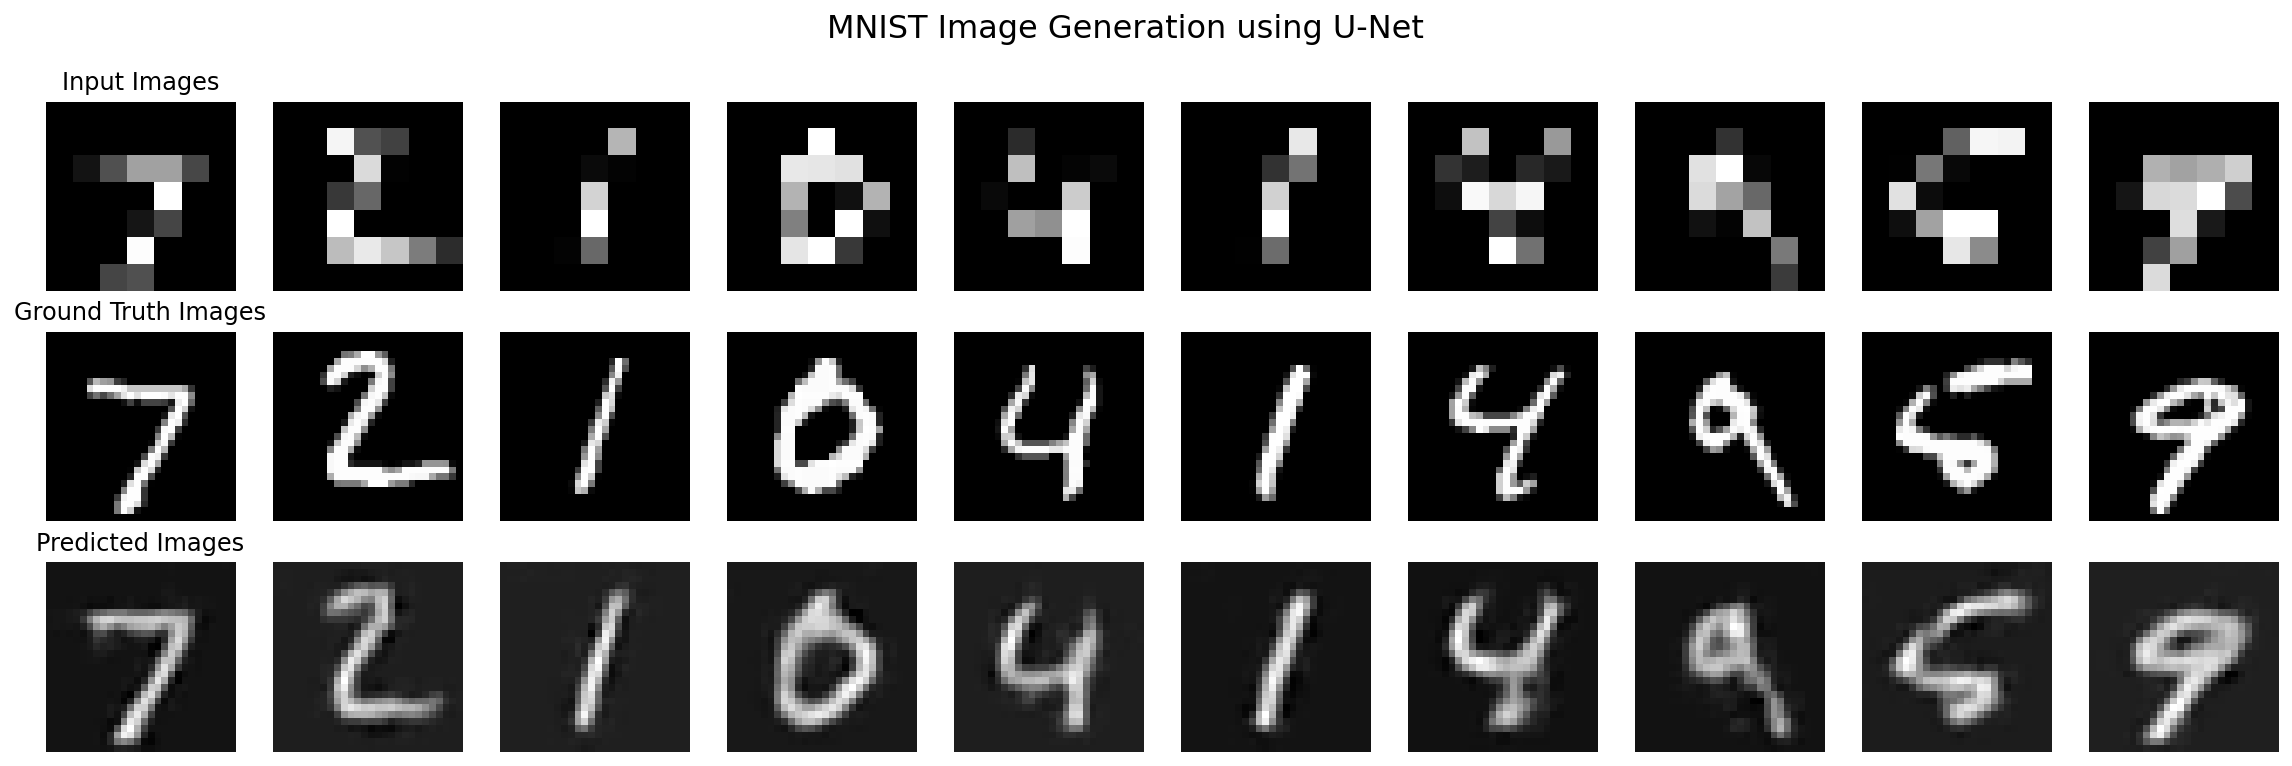

In [102]:
# Get unseen images from the test set
X_test = mnist_test_small.float().to(device)
Y_test = mnist_test_large.float().to(device)

# Forward pass
Y_hat = model(X_test)

plot_images(X_test.cpu(), Y_test.cpu(), Y_hat.cpu())
